# Imports

In [1]:
%load_ext autoreload

In [19]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from yaml import YAMLObject

import matplotlib
import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
from numpy import ndarray
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState
from progressbar import progressbar as pbar
from enum import Enum
import re
from enum import Enum
from matplotlib import patches
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection
from matplotlib import ticker

from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    VolumeCropSequence, MetaCrop3DGenerator, VSConstantEverywhere, 
    GTConstantEverywhere, SequentialGridPosition, ET3DConstantEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg.data import EstimationVolume
from tomo2seg import AggregationStrategy

# Setup

In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())

In [5]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  
logger.debug(f"{strategy=}")

DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:001}::[2020-12-01::22:45:47.902]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:002}::[2020-12-01::22:45:47.906]
Num GPUs Available: 0
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:003}::[2020-12-01::22:45:47.964]
Both here should return 2 devices...
tf.config.list_physical_devices('GPU')=[]
tf.config.list_logical_devices('GPU')=[]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:011}::[2020-12-01::22:45:47.970]
strategy=<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7feda5b9ffa0>



# Options

In [6]:
# crop_shape = (320, 320, 1)
crop_shape = (245, 245, 1)

logger.info(f"{crop_shape=}")

INFO::tomo2seg::{<ipython-input-6-8442425e924c>:<module>:004}::[2020-12-01::22:45:48.036]
crop_shape=(245, 245, 1)



# tomo2seg objects

**tomo2seg.Volume**

In [7]:
from tomo2seg.datasets import (
#     VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=}")
logger.info(f"{volume_version=}")
logger.info(f"{labels_version=}")

volume = Volume.with_check(
    name=volume_name, version=volume_version
)

logger.info(f"{volume=}")

def _read_raw(path_: Path, volume_: Volume, dims=None): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=dims or volume.metadata.dimensions,
        verbose=True,
    )

read_raw = functools.partial(_read_raw, volume_=volume)

INFO::tomo2seg::{<ipython-input-7-1487f00d540d>:<module>:010}::[2020-12-01::22:45:48.084]
volume_name='PA66GF30'

INFO::tomo2seg::{<ipython-input-7-1487f00d540d>:<module>:011}::[2020-12-01::22:45:48.087]
volume_version='v1-reduced'

INFO::tomo2seg::{<ipython-input-7-1487f00d540d>:<module>:012}::[2020-12-01::22:45:48.093]
labels_version='refined3'

DEBUG::tomo2seg::{data.py:with_check:237}::[2020-12-01::22:45:48.094]
vol=Volume(name='PA66GF30', version='v1-reduced', _metadata=None)

ERROR::tomo2seg::{data.py:with_check:255}::[2020-12-01::22:45:48.096]
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.labels.raw

Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.weights.raw

DEBUG::tomo2seg::{data.py:metadata:194}::[2020-12-01::22:45:48.099]
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.metadata.yml`.

INFO::tomo2seg::{<ipython-input

**partition**

In [8]:
partition = volume.train_partition
# partition = volume.val_partition
# partition = volume.test_partition

volume_and_partition_name = f"{volume.fullname}.partition={partition.alias}"

logger.debug(f"{partition=}")
logger.debug(f"{volume_and_partition_name=}")

DEBUG::tomo2seg::{<ipython-input-8-89213c9f1bd2>:<module>:007}::[2020-12-01::22:45:48.170]
partition=SetPartition(x_range=(0, 256), y_range=(0, 256), z_range=(0, 128), alias='train')

DEBUG::tomo2seg::{<ipython-input-8-89213c9f1bd2>:<module>:008}::[2020-12-01::22:45:48.171]
volume_and_partition_name='PA66GF30.v1-reduced.partition=train'



# Load data

**labels**

In [9]:
labels_volume = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{labels_volume.shape=}")

labels_volume = partition.get_volume_partition(labels_volume)
logger.debug(f"(only {partition.alias=}): {labels_volume.shape=}")

data type is uint8
volume size is 256 x 256 x 256
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-9-94afea97c67b>:<module>:002}::[2020-12-01::22:45:48.270]
labels_volume.shape=(256, 256, 256)

DEBUG::tomo2seg::{<ipython-input-9-94afea97c67b>:<module>:005}::[2020-12-01::22:45:48.271]
(only partition.alias='train'): labels_volume.shape=(256, 256, 128)



# label percentage per crop

## count

In [10]:
vollabels = labels_volume

voldata = np.zeros_like(vollabels).astype(np.float16)  # i wont really use the data

labelslist = list(volume.metadata.labels)

vol_shape = vollabels.shape

crop_seq = VolumeCropSequence(
    data_volume=voldata,
    labels_volume=vollabels,
    
    labels=labelslist,
    
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=vol_shape,
        crop_shape=crop_shape,
        x0y0z0_generator= (pos_gen := SequentialGridPosition.build_all_positions(
            volume_shape=vol_shape,
            crop_shape=crop_shape,
        )),
        et_field=ET3DConstantEverywhere.build_no_displacement(grid_position_generator=pos_gen),
        gt_field=GTConstantEverywhere.build_gt2d_identity(grid_position_generator=pos_gen),
        vs_field=VSConstantEverywhere.build_no_shift(grid_position_generator=pos_gen),
    ),
    
    batch_size=1,
    epoch_size=len(pos_gen),
    output_as_2d=False,
)

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:431}::[2020-12-01::22:45:48.389]
Built SequentialGridPosition from volume_shape=(256, 256, 128) and crop_shape=(245, 245, 1) ==> {'x_range': (0, 12), 'y_range': (0, 12), 'z_range': (0, 128)}

INFO::tomo2seg::{volume_sequence.py:__post_init__:479}::[2020-12-01::22:45:48.443]
The SequentialGridPosition has len(self.positions)=18432 different positions (therefore crops).

Initializing ET3DConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing GTConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing VSConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_range values will be overwritten.

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:1279}::[2020-12-01::22:45:48.446]
Initializing VolumeCropSequence.

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:1289}::[2020-12-01::22:45:48.448]
Checking value

**ATTENTION** 

The crop sequence object is stateful! 

Do **not** interrupt of execute twice. The cell above must be executed again.

**labels per crop count**

In [11]:
labels_count = np.empty(
    (
        pos_gen.n_steps_x, 
        pos_gen.n_steps_y, 
        pos_gen.n_steps_z, 
        len(labelslist)
    ),
    dtype=np.int
)
logger.debug(f"{labels_count.shape=}")

for idx in pbar(range(len(crop_seq))):
    (_, crop_y), meta = crop_seq.__getitem_with_meta__(1)
    
    crop_y = crop_y[0, :, :]
    meta = meta[0]
    
    i, j, k = meta.x.start, meta.y.start, meta.z.start
    
    for label_idx in range(labels_count.shape[-1]):
        labels_count[i, j, k, label_idx] = (
            crop_y == label_idx
        ).astype(np.int).sum()

DEBUG::tomo2seg::{<ipython-input-11-568f7f9594dc>:<module>:010}::[2020-12-01::22:45:48.925]
labels_count.shape=(12, 12, 128, 3)



100% (18432 of 18432) |##################| Elapsed Time: 0:01:31 Time:  0:01:31


In [12]:
ncrops = len(crop_seq)
logger.debug(f"{ncrops=}")

ncrops_str = humanize.intcomma(ncrops)

DEBUG::tomo2seg::{<ipython-input-12-b1592dcc35ed>:<module>:002}::[2020-12-01::22:47:20.666]
ncrops=18432



**labels percentage per crop**

In [13]:
labels_perc = labels_count / labels_count.sum(axis=-1, keepdims=True)
# it's more stable to divide it twice to make sure that the sum = 1
labels_perc /= labels_perc.sum(axis=-1, keepdims=True)
labels_perc *= 100.

In [14]:
assert np.all(np.isclose(labels_perc.sum(axis=-1), 100., atol=1e-6))  # 1e-6 = 100 * 1e-8

## distrib $\text{%}_{fiber}$

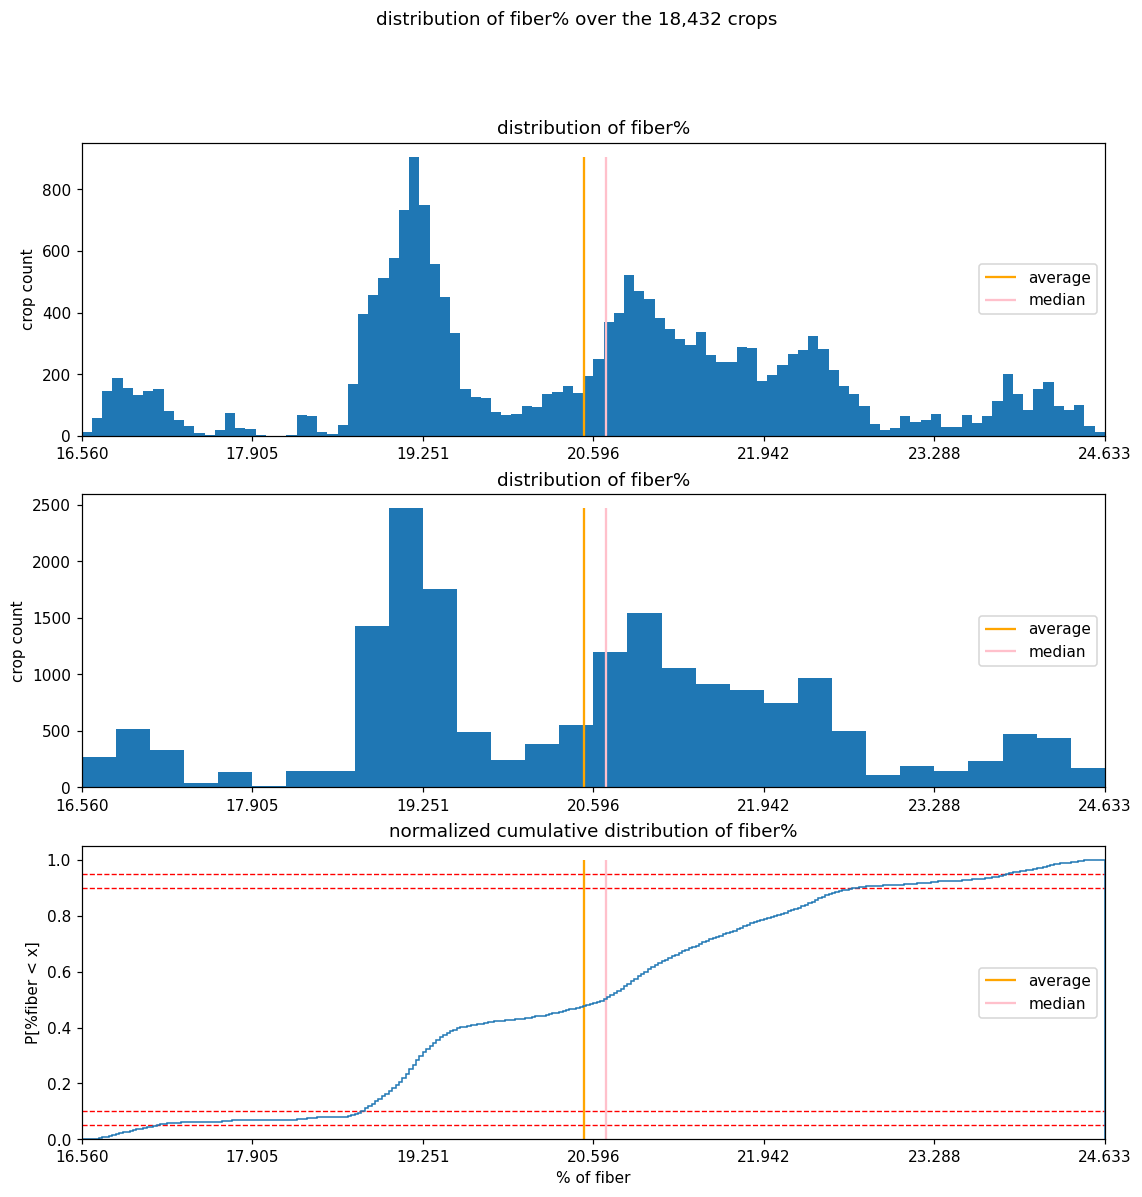

In [15]:
label_idx = 1
label_name = volume.metadata.labels_names[label_idx]
label_percs = labels_perc[:, :, :, label_idx].ravel()

avg = np.average(label_percs)
median = np.median(label_percs)

fig, axs = plt.subplots(nrows := 3, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].hist(label_percs, bins=100)
axs[1].hist(label_percs, bins=30)

axs[-1].hist(label_percs, bins=300, cumulative=True, histtype="step", density=True);

axs[-1].hlines([.05, .10, .90, .95], label_percs.min(), label_percs.max(), color='r', ls='--', linewidth=.9)

fig.suptitle(f"distribution of {label_name}% over the {ncrops_str} crops")
axs[-1].set_xlabel(f"% of {label_name}")
axs[-1].set_title(f"normalized cumulative distribution of {label_name}%")
axs[-1].set_ylabel(f"P[%{label_name} < x]")
x_interval = axs[-1].xaxis.get_data_interval()
axs[-1].set_xlim(x_interval)
axs[-1].set_xticks(np.linspace(*x_interval, 7))
for ax in axs[:-1]:
    ax.set_title(f"distribution of {label_name}%")
    ax.set_ylabel(f"crop count")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
for ax in axs:
    ax.vlines([avg], *ax.yaxis.get_data_interval(), color="orange", label="average")
    ax.vlines([median], *ax.yaxis.get_data_interval(), color="pink", label="median")    
    ax.legend(loc="right")

## distrib $\text{%}_{porosity}$

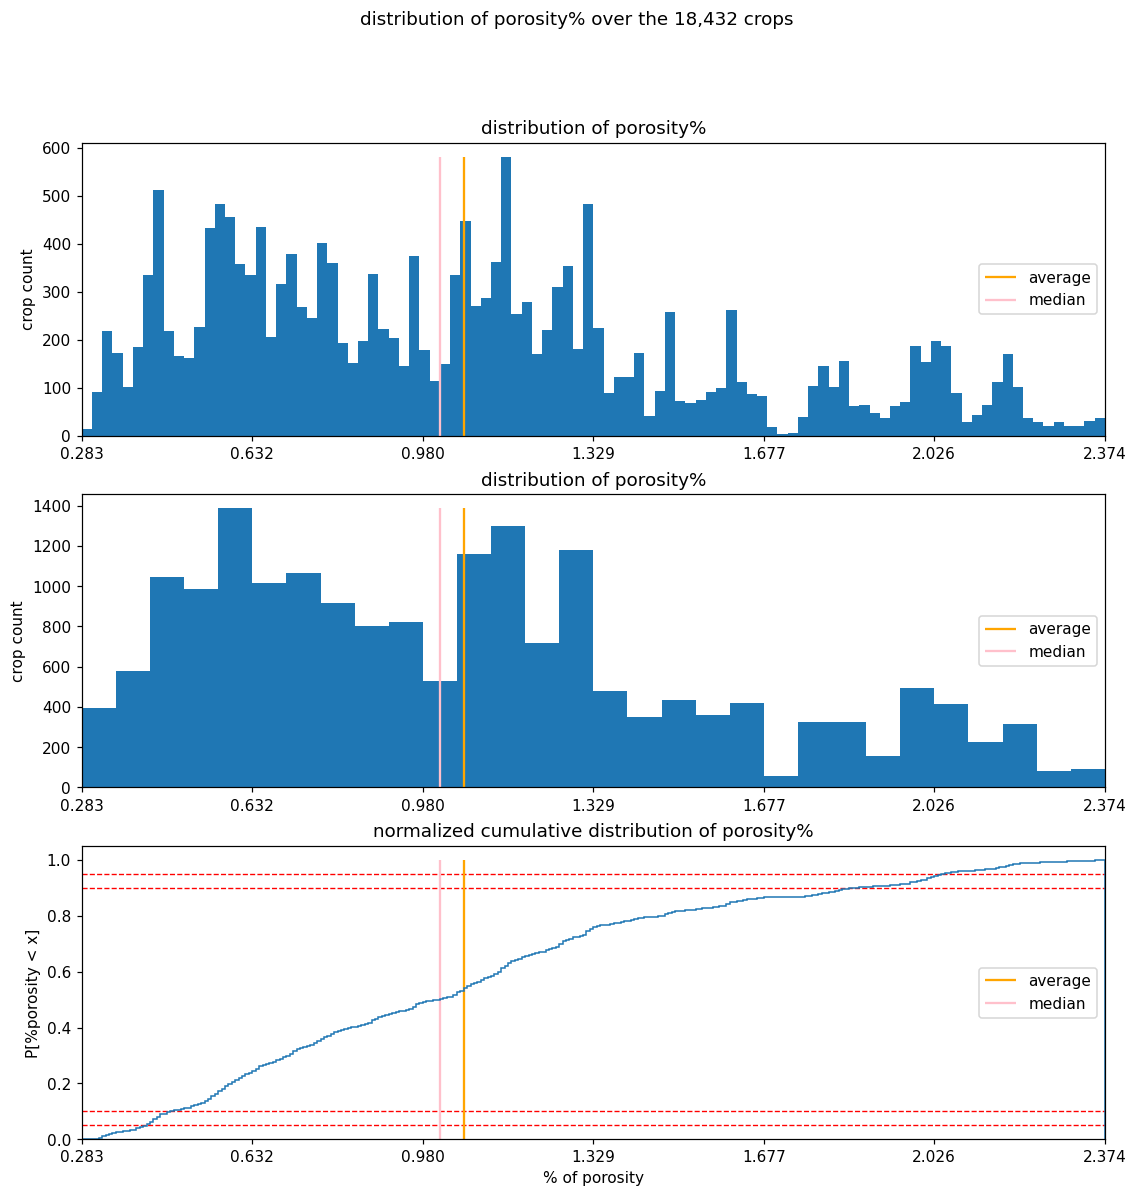

In [16]:
label_idx = 2
label_name = volume.metadata.labels_names[label_idx]
label_percs = labels_perc[:, :, :, label_idx].ravel()

avg = np.average(label_percs)
median = np.median(label_percs)

fig, axs = plt.subplots(nrows := 3, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].hist(label_percs, bins=100)
axs[1].hist(label_percs, bins=30)

axs[-1].hist(label_percs, bins=300, cumulative=True, histtype="step", density=True);

axs[-1].hlines([.05, .10, .90, .95], label_percs.min(), label_percs.max(), color='r', ls='--', linewidth=.9)

fig.suptitle(f"distribution of {label_name}% over the {ncrops_str} crops")
axs[-1].set_xlabel(f"% of {label_name}")
axs[-1].set_title(f"normalized cumulative distribution of {label_name}%")
axs[-1].set_ylabel(f"P[%{label_name} < x]")
x_interval = axs[-1].xaxis.get_data_interval()
axs[-1].set_xlim(x_interval)
axs[-1].set_xticks(np.linspace(*x_interval, 7))
for ax in axs[:-1]:
    ax.set_title(f"distribution of {label_name}%")
    ax.set_ylabel(f"crop count")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
for ax in axs:
    ax.vlines([avg], *ax.yaxis.get_data_interval(), color="orange", label="average")
    ax.vlines([median], *ax.yaxis.get_data_interval(), color="pink", label="median")    
    ax.legend(loc="right")

## distrib ($\text{%}_{fiber}$, $\text{%}_{porosity}$)

In [17]:
x_label_idx, y_label_idx = 1, 2

x_label_name, y_label_name = [volume.metadata.labels_names[idx] for idx in [x_label_idx, y_label_idx]]

x_label_percs = labels_perc[:, :, :, x_label_idx].ravel()
y_label_percs = labels_perc[:, :, :, y_label_idx].ravel()

h, xedges, yedges = np.histogram2d(
    x_label_percs, 
    y_label_percs, 
#     bins=(30, 30), 
    bins=(50, 50), 
#     bins=(100, 100), 
)

h /= h.sum()

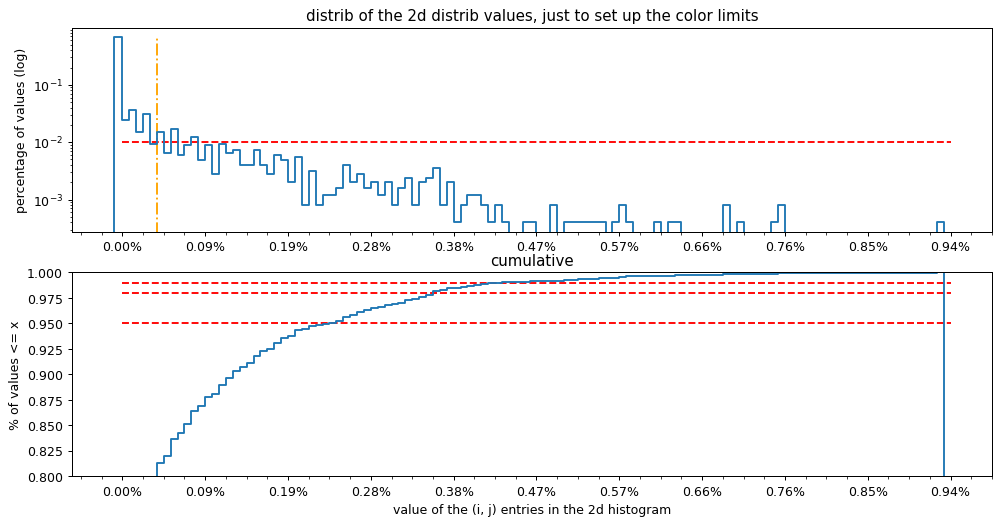

In [20]:
label_couple_percs = h.ravel()

vals_, bins = np.histogram(label_couple_percs, bins=(n_bins:=120))
vals = vals_ / vals_.sum()  # sum is the number of bins in the 2d hist
vals_cum = np.cumsum(vals_) / vals_.sum()  # sum is the number of bins in the 2d hist

fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(4 * ncols * (sz := 3.3), nrows * sz), sharex=True, dpi=90)

axs[0].step([bins[0] - .0001] + bins.tolist(), [0] + vals.tolist() + [0]);  # make vertical lines in the ends
x_interval = np.min(label_couple_percs), np.max(label_couple_percs)
y_interval = axs[0].yaxis.get_data_interval()

axs[0].set_yscale("log")
axs[0].hlines([.01], *x_interval, color='r', ls='--')
axs[0].set_title("distrib of the 2d distrib values, just to set up the color limits")
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)
axs[0].set_ylabel("percentage of values (log)")

axs[1].step([bins[0] - .0001] + bins.tolist(), [0] + vals_cum.tolist() + [0]);
axs[1].hlines([.95, .98, .99], *x_interval, color='r', ls='--')
axs[1].set_ylim(.80, 1)
axs[1].set_xlabel("value of the (i, j) entries in the 2d histogram")
axs[1].set_title("cumulative")
axs[1].set_ylabel("% of values <= x")
axs[1].set_xticks(np.linspace(*x_interval, 11))
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2%}"))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

for ax in axs:
    ax.vlines([1 / label_couple_percs.shape[0] ], *y_interval, color='orange', ls='-.')

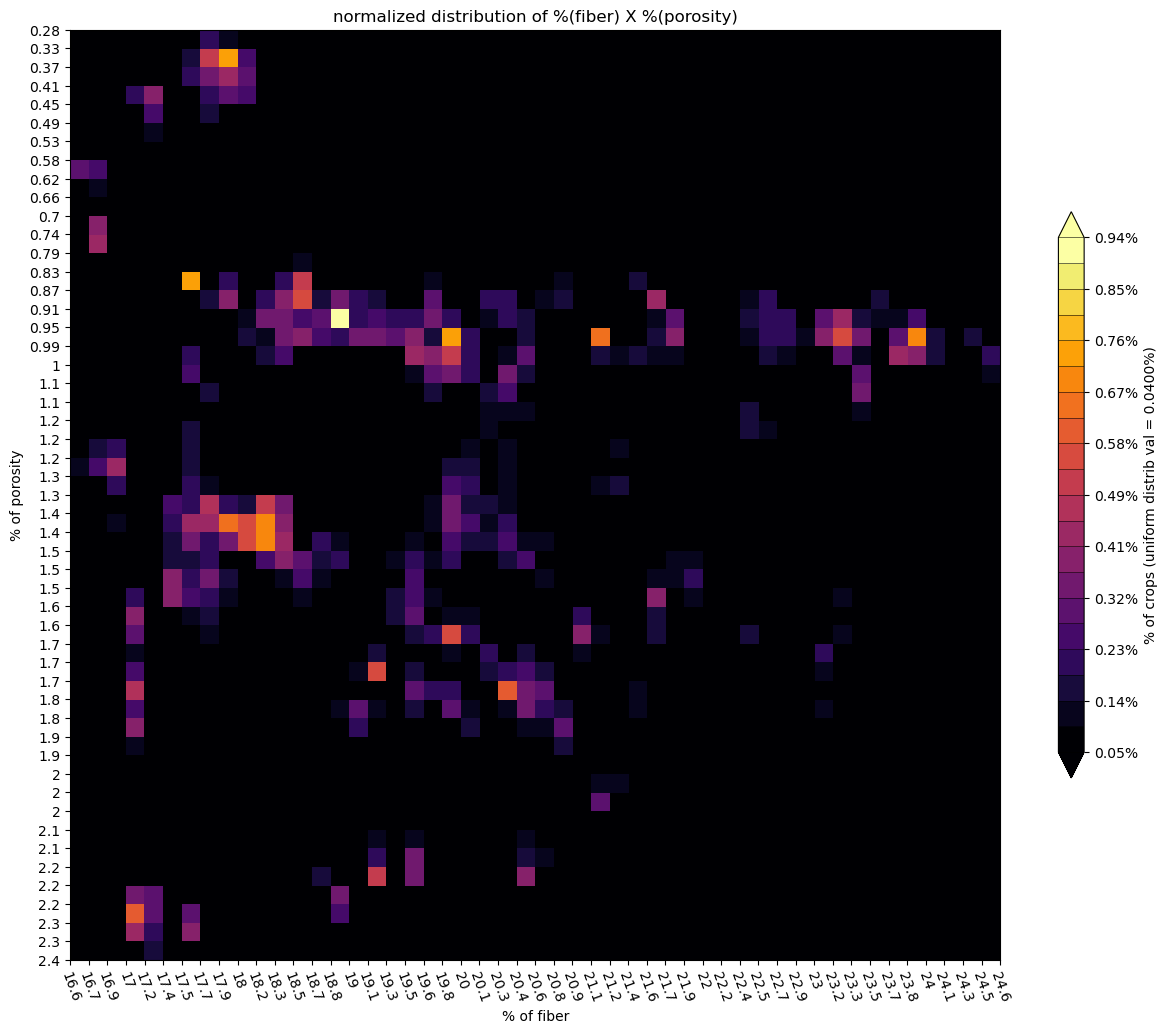

In [21]:
fig, ax = plt.subplots(nrows := 1, ncols := 1, figsize=(ncols * (sz := 15), nrows * sz), dpi=100)

im = ax.imshow(
    h,
    cmap=cm.get_cmap("inferno", (im_ncolors := 20)),
    vmin=(im_vmin := 0.0005),
#     vmin=0.0,
#     vmax=0.006,
    vmax=(im_vmax := 0.0094),
)

ax.set_title(f"normalized distribution of %({x_label_name}) X %({y_label_name})")

ax.set_xlabel(f"% of {volume.metadata.labels_names[x_label_idx]}")
ax.set_xticks(np.linspace(-.5, xedges.shape[0] - 1.5, xedges.shape[0]))
ax.set_xticklabels([f"{e:.3g}" for e in xedges])
ax.xaxis.set_tick_params(which='both', rotation=-70)

ax.set_ylabel(f"% of {volume.metadata.labels_names[y_label_idx]}")
ax.set_yticks(np.linspace(-.5, yedges.shape[0] - 1.5, yedges.shape[0]))
ax.set_yticklabels([f"{e:.2g}" for e in yedges]);

fig.colorbar(
    im, 
    shrink=.5, 
    extend="both", 
    drawedges=True,
    label=f"% of crops (uniform distrib val = {1 / h.size:.4%})",
    format=ticker.StrMethodFormatter("{x:.2%}"),
    ticks=np.linspace(im_vmin, im_vmax, min(11, im_ncolors + 1)),
) 

## porosity x {i, j, k}

In [22]:
shape = labels_perc.shape[:3]

i_vol = np.stack([
    i * np.ones((shape[1], shape[2]), dtype=np.int)
    for i in range(shape[0])
], axis=0)

j_vol = np.stack([
    j * np.ones((shape[0], shape[2]), dtype=np.int)
    for j in range(shape[1])
], axis=1)

k_vol = np.stack([
    k * np.ones((shape[0], shape[1]), dtype=np.int)
    for k in range(shape[2])
], axis=2)

dir_vols = [i_vol, j_vol, k_vol]

Text(0.5, 0, 'position in the crop grid on direction=0 + xjitter=0.24 (xjitter_relative=0.02)')

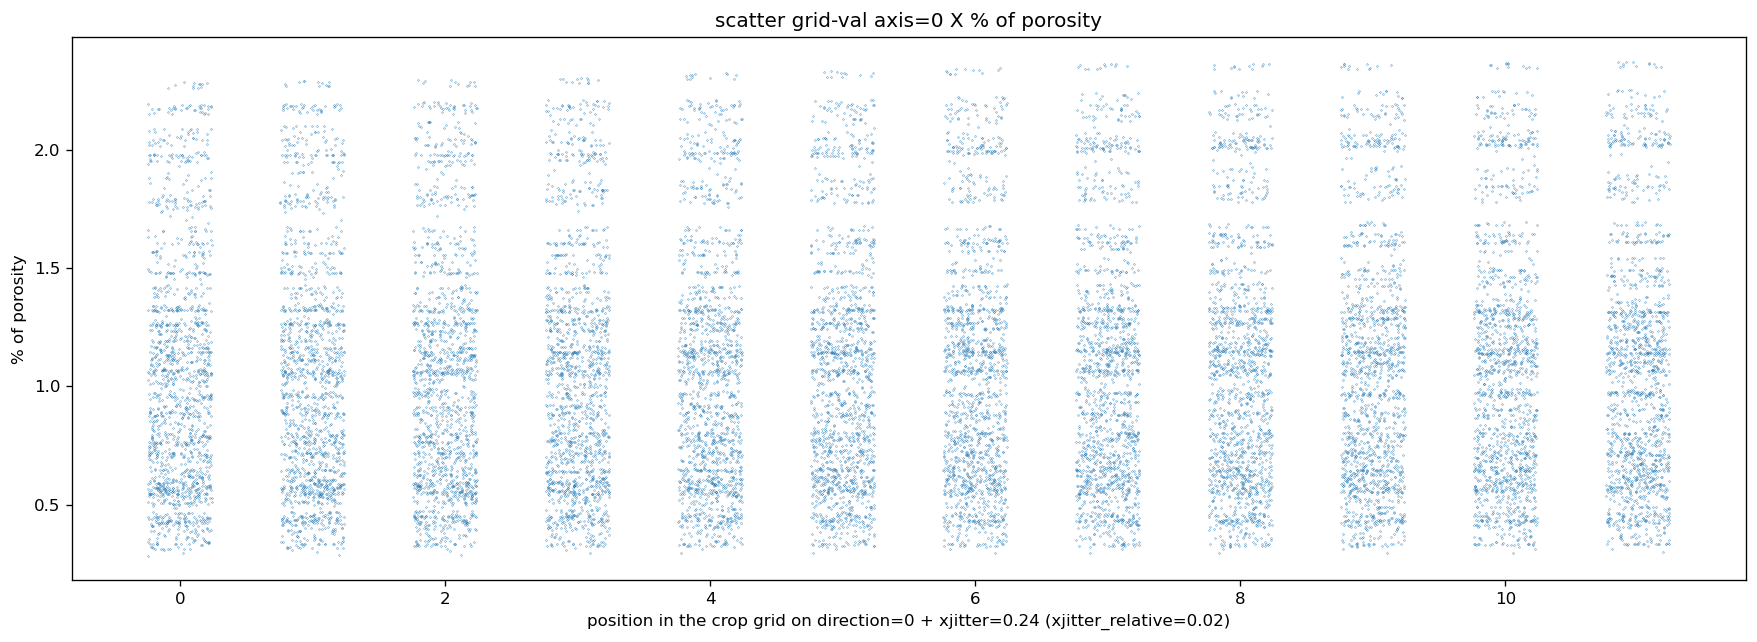

In [23]:
label_idx = 2  # porosity
label_name = volume.metadata.labels_names[label_idx]
dir = 0  # x, y, z
xjitter_relative = .02

dir_vol = dir_vols[dir]
label_perc_vol = labels_perc[:, :, :, label_idx]

xjitter = xjitter_relative * shape[dir]

fig, ax = plt.subplots(nrows := 1, ncols := 1, figsize=(3 * ncols * (sz := 6), nrows * sz), dpi=120)

ax.scatter(
    dir_vol.ravel() + np.random.uniform(-xjitter, xjitter, dir_vol.size),
    label_perc_vol.ravel(),
    s=.2,
    marker='.',
)
ax.set_title(f"scatter grid-val axis={dir} X % of {label_name}")
ax.set_ylabel(f"% of {label_name}")
ax.set_xlabel(f"position in the crop grid on direction={dir} + {xjitter=} ({xjitter_relative=})")

Text(0.5, 0, 'position in the crop grid on direction=1 + xjitter=0.24 (xjitter_relative=0.02)')

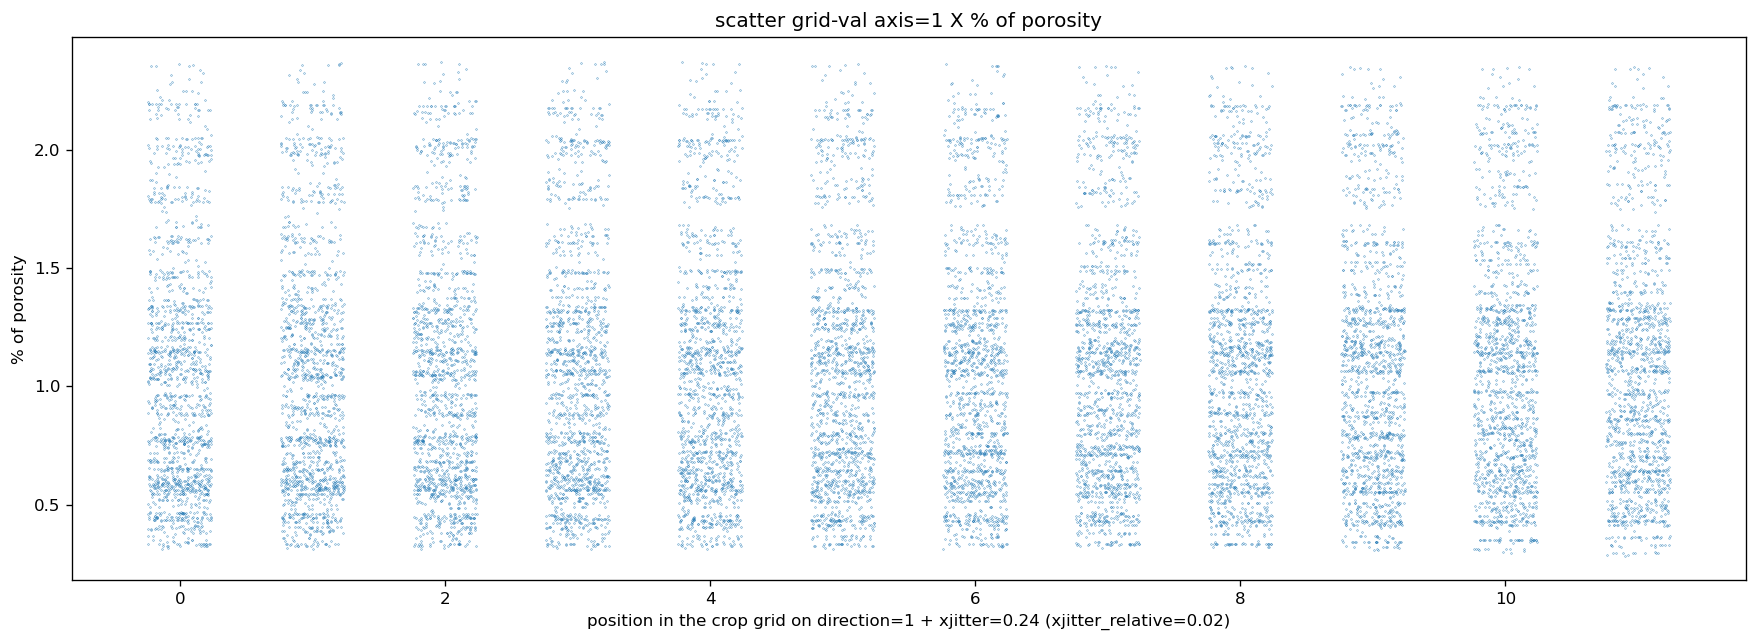

In [24]:
label_idx = 2  # porosity
label_name = volume.metadata.labels_names[label_idx]
dir = 1  # x, y, z
xjitter_relative = .02

dir_vol = dir_vols[dir]
label_perc_vol = labels_perc[:, :, :, label_idx]

xjitter = xjitter_relative * shape[dir]

fig, ax = plt.subplots(nrows := 1, ncols := 1, figsize=(3 * ncols * (sz := 6), nrows * sz), dpi=120)

ax.scatter(
    dir_vol.ravel() + np.random.uniform(-xjitter, xjitter, dir_vol.size),
    label_perc_vol.ravel(),
    s=.2,
    marker='.',
)
ax.set_title(f"scatter grid-val axis={dir} X % of {label_name}")
ax.set_ylabel(f"% of {label_name}")
ax.set_xlabel(f"position in the crop grid on direction={dir} + {xjitter=} ({xjitter_relative=})")

Text(0.5, 0, 'position in the crop grid on direction=2 + xjitter=0.128 (xjitter_relative=0.001)')

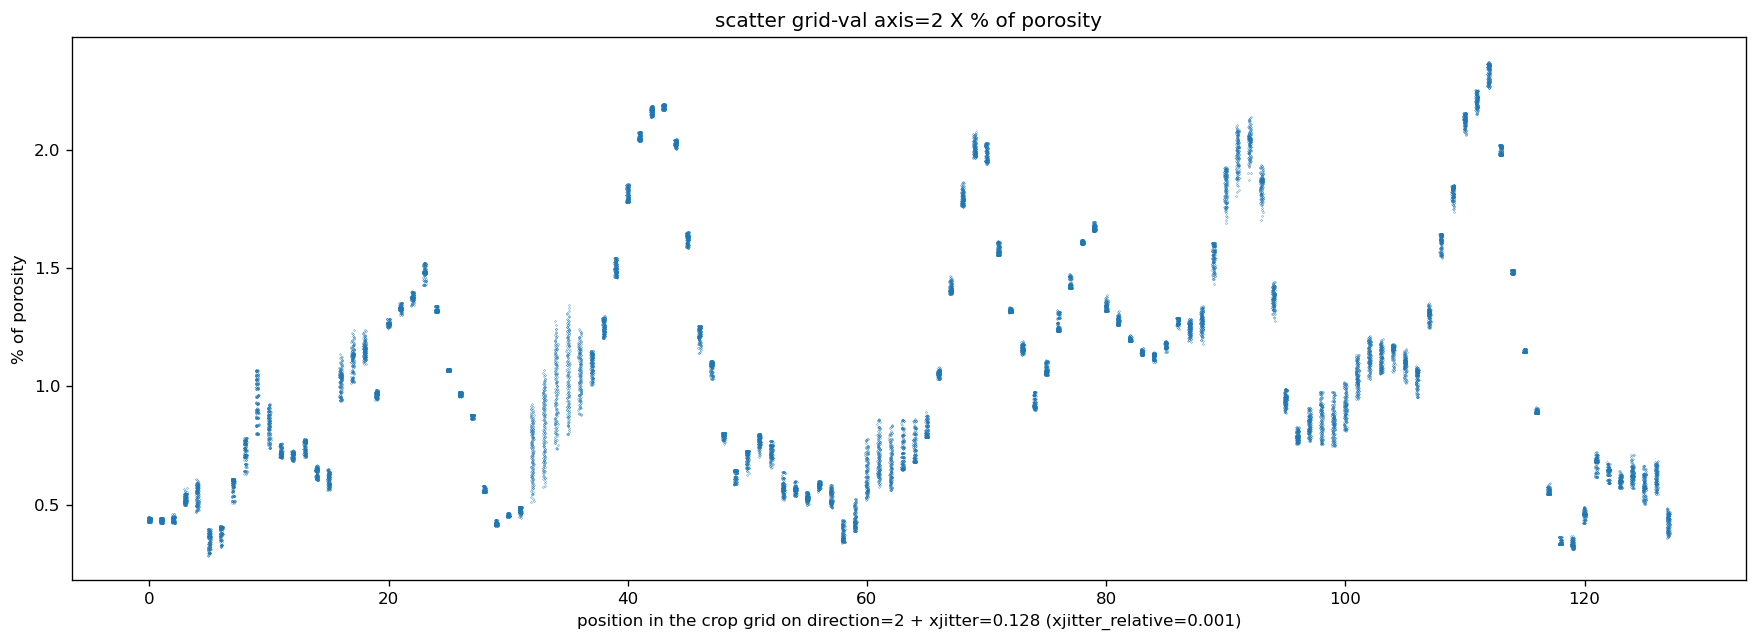

In [25]:
label_idx = 2  # porosity
label_name = volume.metadata.labels_names[label_idx]
dir = 2  # x, y, z
xjitter_relative = .001

dir_vol = dir_vols[dir]
label_perc_vol = labels_perc[:, :, :, label_idx]

xjitter = xjitter_relative * shape[dir]

fig, ax = plt.subplots(nrows := 1, ncols := 1, figsize=(3 * ncols * (sz := 6), nrows * sz), dpi=120)

ax.scatter(
    dir_vol.ravel() + np.random.uniform(-xjitter, xjitter, dir_vol.size),
    label_perc_vol.ravel(),
    s=.2,
    marker='.',
)
ax.set_title(f"scatter grid-val axis={dir} X % of {label_name}")
ax.set_ylabel(f"% of {label_name}")
ax.set_xlabel(f"position in the crop grid on direction={dir} + {xjitter=} ({xjitter_relative=})")

# $P[i, j, k] = f(\text{%}_{porosity})$

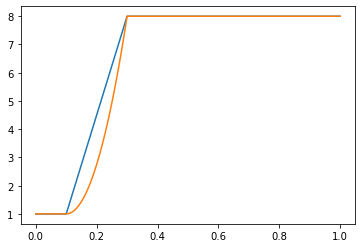

In [26]:
def generic_percentage2logit(
    percentages: ndarray, 
    percent_clip_min: int, 
    percent_clip_max: int, 
    logit_min: float, 
    logit_max: float,
    max_value_is_100: bool = False,
    power: float = 1.
) -> ndarray:
    """
    logit is something that will be used to compute a probability with the resultant array
    probas = return / np.sum(return)
    
    """
    assert 0 <= percent_clip_min < percent_clip_max <= (100 if max_value_is_100 else 1), f"{percent_clip_min=} {percent_clip_max=} {max_value_is_100=}"
    
    cliped_percentages = np.clip(
        (percentages - percent_clip_min) / (percent_clip_max - percent_clip_min), 
        a_min=0, 
        a_max=1
    )

    logit_range = logit_max - logit_min
    
    return logit_range * (cliped_percentages ** power) + logit_min

test_percentage2logit = functools.partial(
    generic_percentage2logit,
    percent_clip_min=.1, 
    percent_clip_max=.3, 
    logit_min=1., 
    logit_max=8.,
)

test_percentages = np.linspace(0, 1, 301)
plt.plot(test_percentages, test_percentage2logit(test_percentages))
plt.plot(test_percentages, test_percentage2logit(test_percentages, power=2))

DEBUG::tomo2seg::{<ipython-input-30-9f77da63ed5e>:<module>:016}::[2020-12-01::22:48:36.175]
MIN function input value (percentage): percentile_min=20 --> percent_min=0.5931

DEBUG::tomo2seg::{<ipython-input-30-9f77da63ed5e>:<module>:017}::[2020-12-01::22:48:36.176]
MAX function input value (percentage): percentile_max=100 --> percent_max=2.374

DEBUG::tomo2seg::{<ipython-input-30-9f77da63ed5e>:<module>:018}::[2020-12-01::22:48:36.177]
Range size of non-saturated percentages (linear function): percent_max - percent_min=1.78092



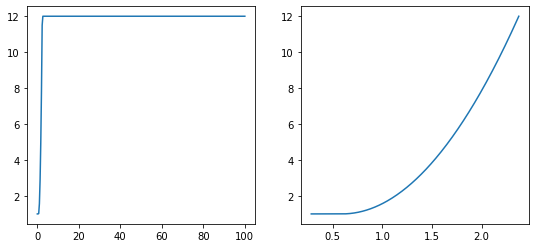

In [30]:
label_idx = 2  # porosity

label_percs_vol = labels_perc[:, :, :, label_idx]

percentile_min = 20
percentile_max = 100

percent_min, percent_max = np.percentile(
    label_percs_vol, 
    [
        percentile_min, 
        percentile_max
    ]
)

logger.debug(f"MIN function input value (percentage): {percentile_min=} --> {percent_min=:.4g}")
logger.debug(f"MAX function input value (percentage): {percentile_max=} --> {percent_max=:.4g}")
logger.debug(f"Range size of non-saturated percentages (linear function): {percent_max - percent_min=:.6g}")

percent2logit = functools.partial(
    generic_percentage2logit,
    percent_clip_min=percent_min, 
    percent_clip_max=percent_max, 
    logit_min=1., 
    logit_max=12.,
    max_value_is_100=True,
    power=2,
)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
test_percentages = np.linspace(0, 100, 301)
axs[0].plot(test_percentages, percent2logit(test_percentages))
test_percentages = np.linspace(label_percs_vol.min(), label_percs_vol.max(), 301)
axs[1].plot(test_percentages, percent2logit(test_percentages))

logits = percent2logit(label_percs_vol)

probas = logits / logits.sum()
probas /= probas.sum()

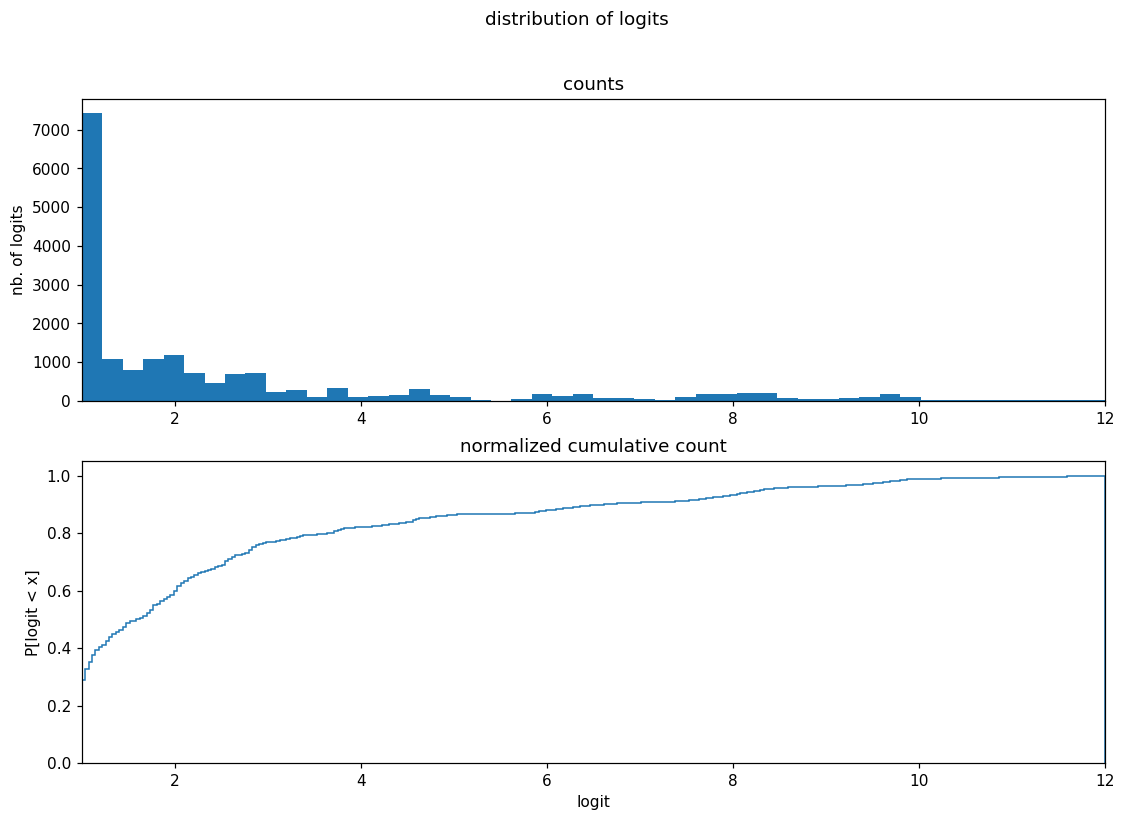

In [31]:
label_idx = 2
label_name = volume.metadata.labels_names[label_idx]
logit_vals = logits.ravel()

fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].hist(logit_vals, bins=50)
axs[-1].hist(logit_vals, bins=300, cumulative=True, histtype="step", density=True);

xinterval = logit_vals.min(), logit_vals.max()

fig.suptitle(f"distribution of logits")
axs[-1].set_xlabel(f"logit")
axs[-1].set_title(f"normalized cumulative count")
axs[-1].set_ylabel(f"P[logit < x]")
x_interval = axs[-1].xaxis.get_data_interval()
axs[-1].set_xlim(x_interval)
for ax in axs[:-1]:
    ax.set_title(f"counts")
    ax.set_ylabel(f"nb. of logits")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

## new $\text{%}_porosity$ distribution

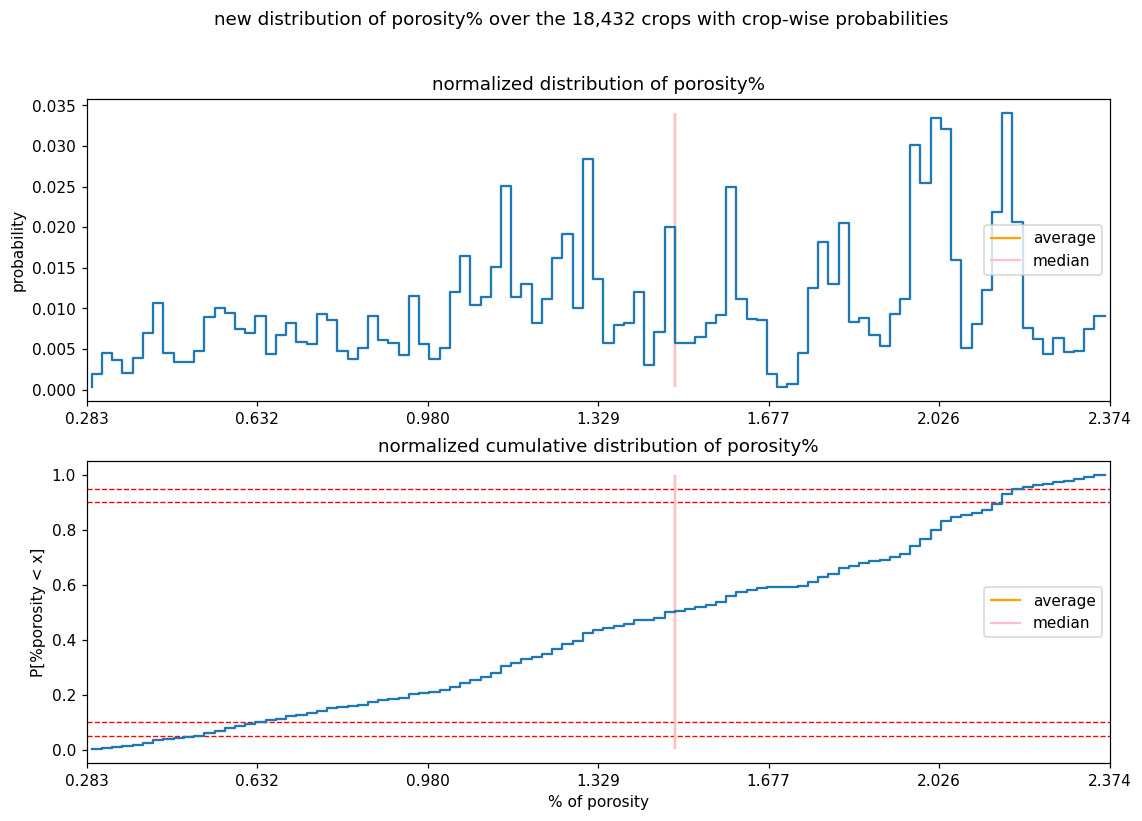

In [32]:
label_idx = 2
label_name = volume.metadata.labels_names[label_idx]
label_percs = labels_perc[:, :, :, label_idx]
nbins = 100

percent_min, percent_max = label_percs.min(), label_percs.max()

bin_edges = np.linspace(percent_min, percent_max, nbins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_probas = np.empty((nbins,))

for bin_idx, (bin_min, bin_max) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    selector = label_percs >= bin_min
    selector &= (label_percs < bin_max) if bin_idx < nbins - 1 else label_percs <= bin_max
    hist_probas[bin_idx] = probas[selector].sum()
    
cum_hist_probas = np.cumsum(hist_probas)
cum_hist_probas /= cum_hist_probas[-1]

avg = np.average(label_percs, weights=probas)

median_bin_idx = np.argmin(np.abs(cum_hist_probas - .5))
median = np.median(bin_centers[median_bin_idx])

fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].step(bin_centers, hist_probas)

axs[-1].step(bin_centers, cum_hist_probas);

axs[-1].hlines([.05, .10, .90, .95], label_percs.min(), label_percs.max(), color='r', ls='--', linewidth=.9)

fig.suptitle(f"new distribution of {label_name}% over the {ncrops_str} crops with crop-wise probabilities")
axs[-1].set_xlabel(f"% of {label_name}")
axs[-1].set_title(f"normalized cumulative distribution of {label_name}%")
axs[-1].set_ylabel(f"P[%{label_name} < x]")
x_interval = bin_edges[0], bin_edges[-1]
axs[-1].set_xlim(x_interval)
axs[-1].set_xticks(np.linspace(*x_interval, 7))
for ax in axs[:-1]:
    ax.set_title(f"normalized distribution of {label_name}%")
    ax.set_ylabel(f"probability")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
for ax in axs:
    ax.vlines([avg], *ax.yaxis.get_data_interval(), color="orange", label="average")
    ax.vlines([median], *ax.yaxis.get_data_interval(), color="pink", label="median")    
    ax.legend(loc="right")

## new $\text{%}_fiber$ distribution

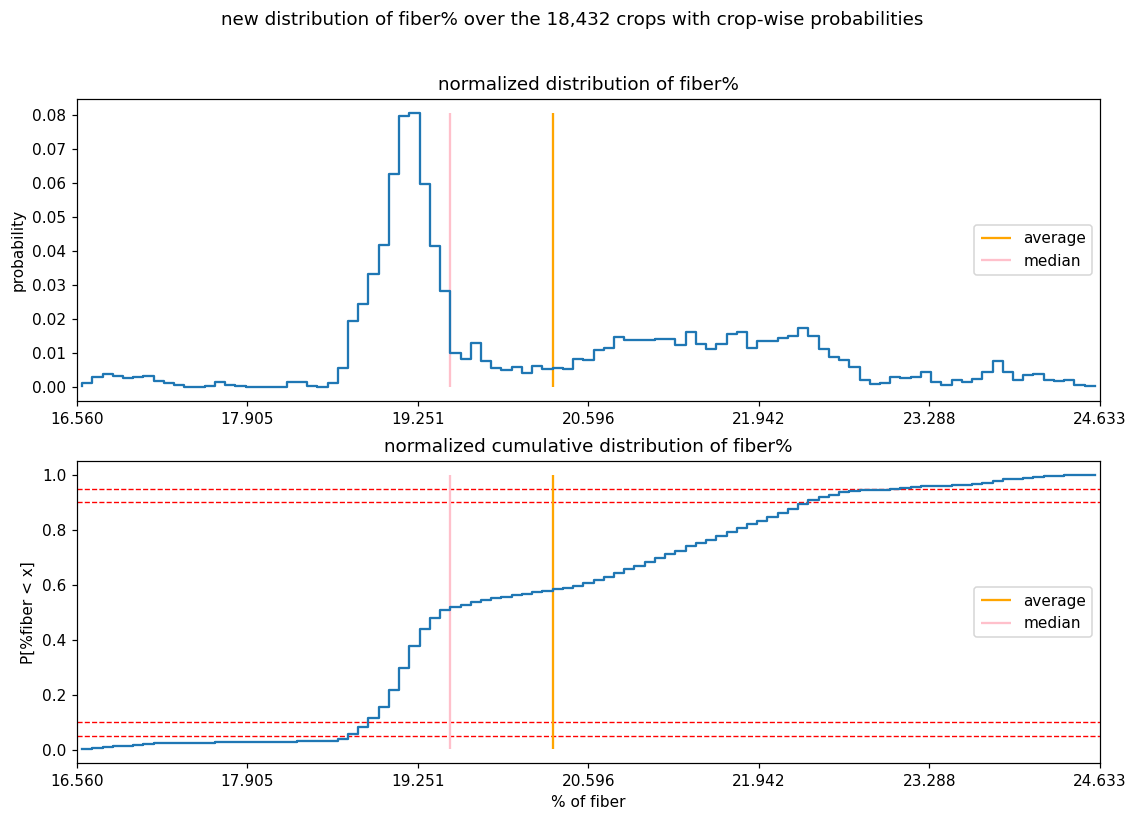

In [33]:
label_idx = 1
label_name = volume.metadata.labels_names[label_idx]
label_percs = labels_perc[:, :, :, label_idx]
nbins = 100

percent_min, percent_max = label_percs.min(), label_percs.max()

bin_edges = np.linspace(percent_min, percent_max, nbins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_probas = np.empty((nbins,))

for bin_idx, (bin_min, bin_max) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    selector = label_percs >= bin_min
    selector &= (label_percs < bin_max) if bin_idx < nbins - 1 else label_percs <= bin_max
    hist_probas[bin_idx] = probas[selector].sum()
    
cum_hist_probas = np.cumsum(hist_probas)
cum_hist_probas /= cum_hist_probas[-1]

avg = np.average(label_percs, weights=probas)

median_bin_idx = np.argmin(np.abs(cum_hist_probas - .5))
median = np.median(bin_centers[median_bin_idx])

fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].step(bin_centers, hist_probas)

axs[-1].step(bin_centers, cum_hist_probas);

axs[-1].hlines([.05, .10, .90, .95], label_percs.min(), label_percs.max(), color='r', ls='--', linewidth=.9)

fig.suptitle(f"new distribution of {label_name}% over the {ncrops_str} crops with crop-wise probabilities")
axs[-1].set_xlabel(f"% of {label_name}")
axs[-1].set_title(f"normalized cumulative distribution of {label_name}%")
axs[-1].set_ylabel(f"P[%{label_name} < x]")
x_interval = bin_edges[0], bin_edges[-1]
axs[-1].set_xlim(x_interval)
axs[-1].set_xticks(np.linspace(*x_interval, 7))
for ax in axs[:-1]:
    ax.set_title(f"normalized distribution of {label_name}%")
    ax.set_ylabel(f"probability")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
for ax in axs:
    ax.vlines([avg], *ax.yaxis.get_data_interval(), color="orange", label="average")
    ax.vlines([median], *ax.yaxis.get_data_interval(), color="pink", label="median")    
    ax.legend(loc="right")

## new (i, j, k) distribution

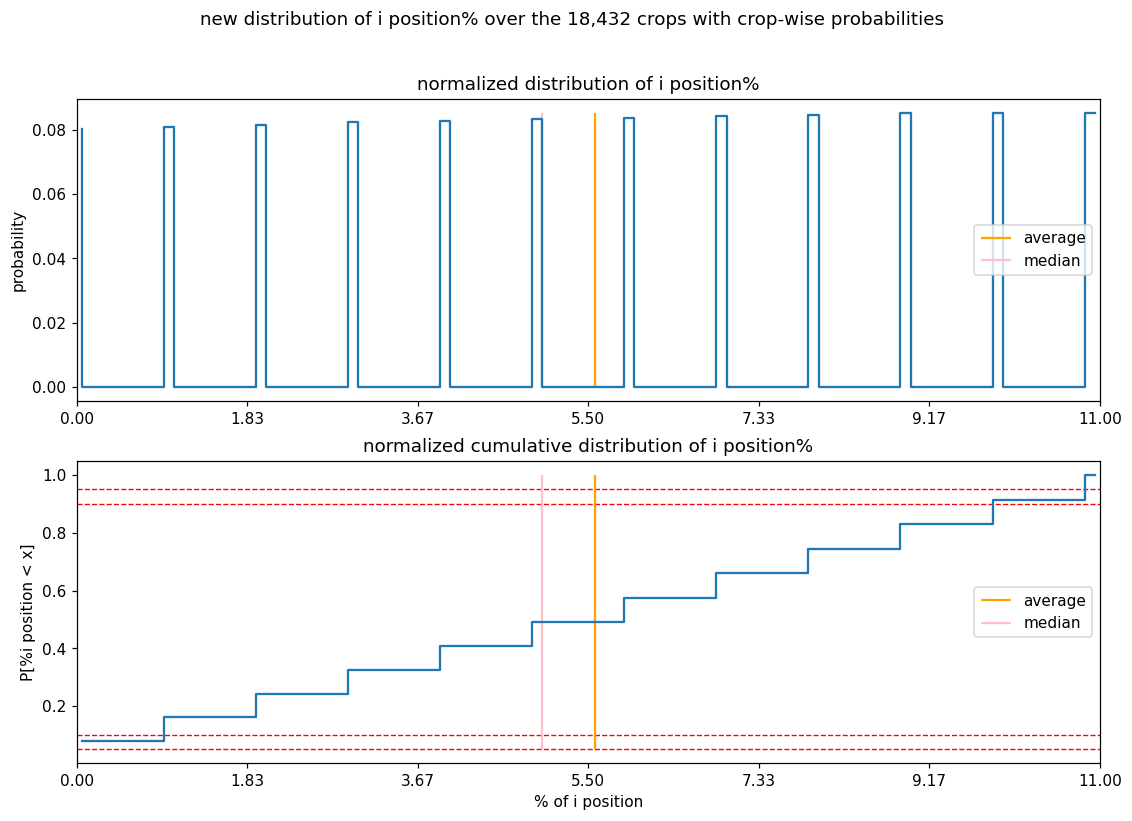

In [34]:
# label_idx = 1
label_name = "i position"
label_percs = i_vol
nbins = 100

percent_min, percent_max = label_percs.min(), label_percs.max()

bin_edges = np.linspace(percent_min, percent_max, nbins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_probas = np.empty((nbins,))

for bin_idx, (bin_min, bin_max) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    selector = label_percs >= bin_min
    selector &= (label_percs < bin_max) if bin_idx < nbins - 1 else label_percs <= bin_max
    hist_probas[bin_idx] = probas[selector].sum()
    
cum_hist_probas = np.cumsum(hist_probas)
cum_hist_probas /= cum_hist_probas[-1]

avg = np.average(label_percs, weights=probas)

median_bin_idx = np.argmin(np.abs(cum_hist_probas - .5))
median = np.median(bin_centers[median_bin_idx])

fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].step(bin_centers, hist_probas)

axs[-1].step(bin_centers, cum_hist_probas);

axs[-1].hlines([.05, .10, .90, .95], label_percs.min(), label_percs.max(), color='r', ls='--', linewidth=.9)

fig.suptitle(f"new distribution of {label_name}% over the {ncrops_str} crops with crop-wise probabilities")
axs[-1].set_xlabel(f"% of {label_name}")
axs[-1].set_title(f"normalized cumulative distribution of {label_name}%")
axs[-1].set_ylabel(f"P[%{label_name} < x]")
x_interval = bin_edges[0], bin_edges[-1]
axs[-1].set_xlim(x_interval)
axs[-1].set_xticks(np.linspace(*x_interval, 7))
for ax in axs[:-1]:
    ax.set_title(f"normalized distribution of {label_name}%")
    ax.set_ylabel(f"probability")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
for ax in axs:
    ax.vlines([avg], *ax.yaxis.get_data_interval(), color="orange", label="average")
    ax.vlines([median], *ax.yaxis.get_data_interval(), color="pink", label="median")    
    ax.legend(loc="right")

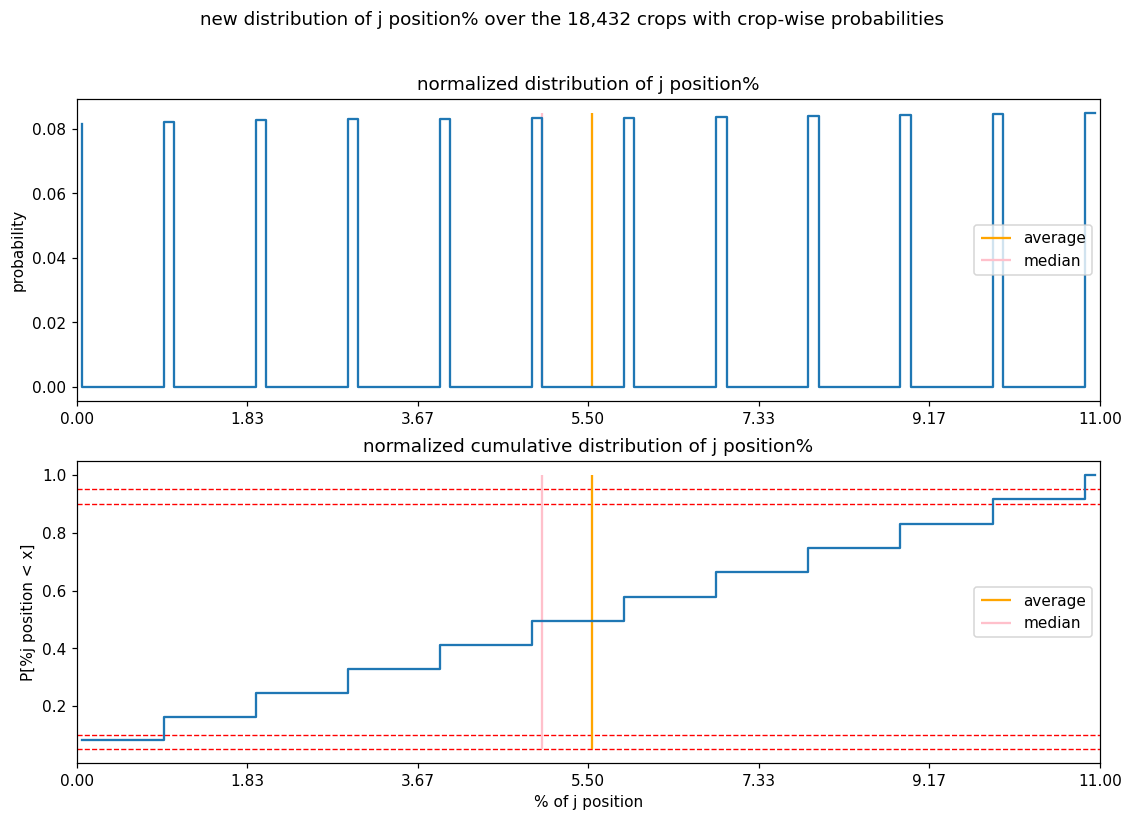

In [35]:
# label_idx = 1
label_name = "j position"
label_percs = j_vol
nbins = 100

percent_min, percent_max = label_percs.min(), label_percs.max()

bin_edges = np.linspace(percent_min, percent_max, nbins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_probas = np.empty((nbins,))

for bin_idx, (bin_min, bin_max) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    selector = label_percs >= bin_min
    selector &= (label_percs < bin_max) if bin_idx < nbins - 1 else label_percs <= bin_max
    hist_probas[bin_idx] = probas[selector].sum()
    
cum_hist_probas = np.cumsum(hist_probas)
cum_hist_probas /= cum_hist_probas[-1]

avg = np.average(label_percs, weights=probas)

median_bin_idx = np.argmin(np.abs(cum_hist_probas - .5))
median = np.median(bin_centers[median_bin_idx])

fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].step(bin_centers, hist_probas)

axs[-1].step(bin_centers, cum_hist_probas);

axs[-1].hlines([.05, .10, .90, .95], label_percs.min(), label_percs.max(), color='r', ls='--', linewidth=.9)

fig.suptitle(f"new distribution of {label_name}% over the {ncrops_str} crops with crop-wise probabilities")
axs[-1].set_xlabel(f"% of {label_name}")
axs[-1].set_title(f"normalized cumulative distribution of {label_name}%")
axs[-1].set_ylabel(f"P[%{label_name} < x]")
x_interval = bin_edges[0], bin_edges[-1]
axs[-1].set_xlim(x_interval)
axs[-1].set_xticks(np.linspace(*x_interval, 7))
for ax in axs[:-1]:
    ax.set_title(f"normalized distribution of {label_name}%")
    ax.set_ylabel(f"probability")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
for ax in axs:
    ax.vlines([avg], *ax.yaxis.get_data_interval(), color="orange", label="average")
    ax.vlines([median], *ax.yaxis.get_data_interval(), color="pink", label="median")    
    ax.legend(loc="right")

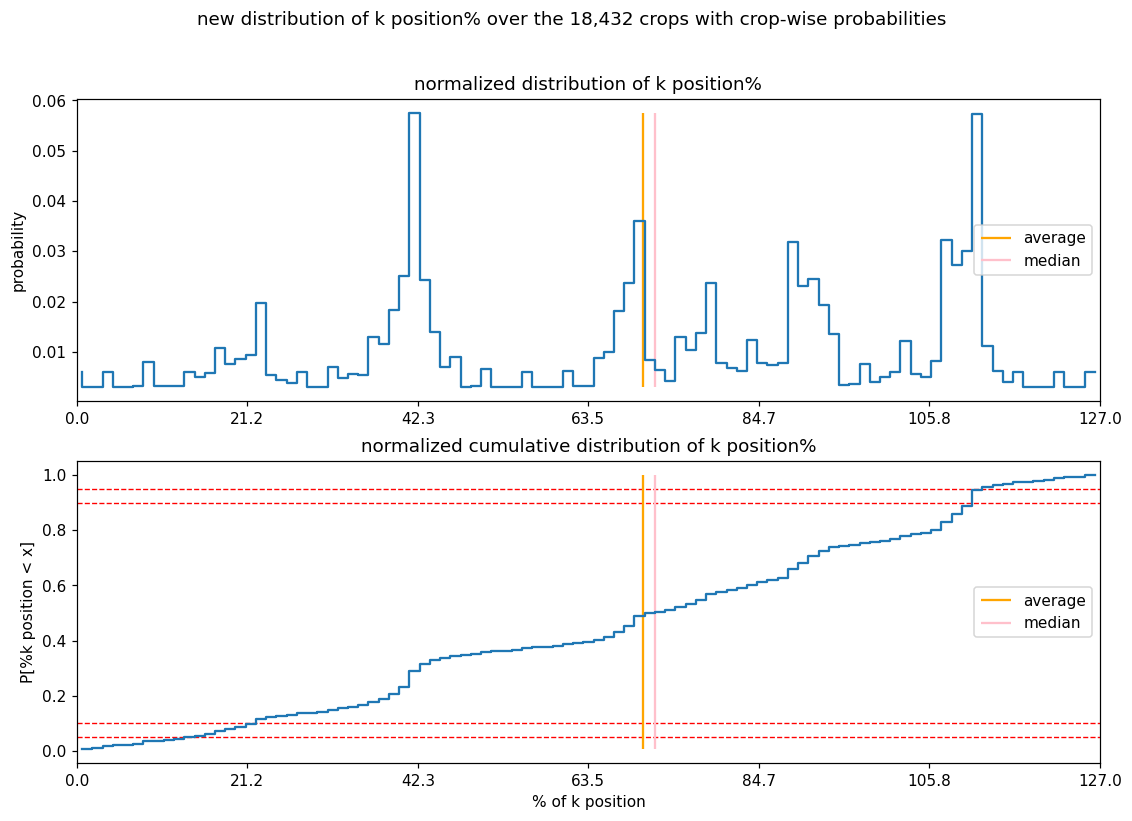

In [38]:
# label_idx = 1
label_name = "k position"
label_percs = k_vol
nbins = 100

percent_min, percent_max = label_percs.min(), label_percs.max()

bin_edges = np.linspace(percent_min, percent_max, nbins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_probas = np.empty((nbins,))

for bin_idx, (bin_min, bin_max) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    selector = label_percs >= bin_min
    selector &= (label_percs < bin_max) if bin_idx < nbins - 1 else label_percs <= bin_max
    hist_probas[bin_idx] = probas[selector].sum()
    
cum_hist_probas = np.cumsum(hist_probas)
cum_hist_probas /= cum_hist_probas[-1]

avg = np.average(label_percs, weights=probas)

median_bin_idx = np.argmin(np.abs(cum_hist_probas - .5))
median = np.median(bin_centers[median_bin_idx])

fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(3 * ncols * (sz := 4), nrows * sz), sharex=True, dpi=110)

axs[0].step(bin_centers, hist_probas)

axs[-1].step(bin_centers, cum_hist_probas);

axs[-1].hlines([.05, .10, .90, .95], label_percs.min(), label_percs.max(), color='r', ls='--', linewidth=.9)

fig.suptitle(f"new distribution of {label_name}% over the {ncrops_str} crops with crop-wise probabilities")
axs[-1].set_xlabel(f"% of {label_name}")
axs[-1].set_title(f"normalized cumulative distribution of {label_name}%")
axs[-1].set_ylabel(f"P[%{label_name} < x]")
x_interval = bin_edges[0], bin_edges[-1]
axs[-1].set_xlim(x_interval)
axs[-1].set_xticks(np.linspace(*x_interval, 7))
for ax in axs[:-1]:
    ax.set_title(f"normalized distribution of {label_name}%")
    ax.set_ylabel(f"probability")
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
for ax in axs:
    ax.vlines([avg], *ax.yaxis.get_data_interval(), color="orange", label="average")
    ax.vlines([median], *ax.yaxis.get_data_interval(), color="pink", label="median")    
    ax.legend(loc="right")

# Save

In [52]:
np.save(
    volume.grid_position_probabilities_path(
        partition=partition,
        crop_shape=crop_shape,
        version="debug",
    ),
    probas,
)